In [1]:
import requests
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
%matplotlib inline
model_path = './'
target_col='price'

In [2]:
data = pd.read_csv("D:/학교/4학년/1학기/캡스톤디자인/농산물 유통정보/양파/data.csv")

In [3]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
data.index = data['date']
del data['date']
del data['Unnamed: 0']
del data['수출(중량)']
del data['수출(금액)']
data.head(3)

,수입(중량),수입(금액),유통비용,생산량,price
date,,,,,
2010-01-04,230808.0,232733.0,72.2,1.411646e+09,1278
2010-01-05,230808.0,232733.0,72.2,1.411646e+09,1293
2010-01-06,230808.0,232733.0,72.2,1.411646e+09,1293


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(data, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

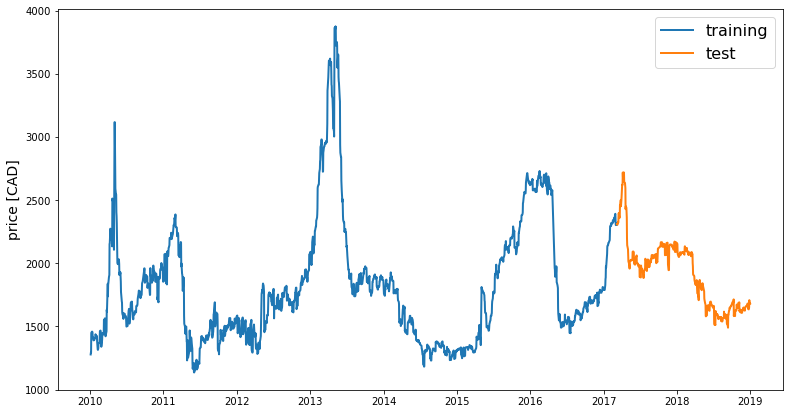

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

##### 스케일 조정하기

In [8]:
#정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['수입(중량)','수입(금액)',
              '유통비용','생산량','price']
learn_data_scaled = scaler.fit_transform(data[scale_cols])

learn_data_scaled = pd.DataFrame(learn_data_scaled, index = data.index)
learn_data_scaled.columns = scale_cols

In [22]:
learn_data_scaled.head()

,수입(중량),수입(금액),유통비용,생산량,price
date,,,,,
2010-01-04,0.00065,0.00378,0.626866,0.640519,0.052190
2010-01-05,0.00065,0.00378,0.626866,0.640519,0.057664
2010-01-06,0.00065,0.00378,0.626866,0.640519,0.057664
2010-01-07,0.00065,0.00378,0.626866,0.640519,0.114599
2010-01-08,0.00065,0.00378,0.626866,0.640519,0.115693


#### 데이터 나누기

In [9]:
train, test = train_test_split(learn_data_scaled, test_size=0.2)

In [10]:
def make_dataset(data, label, window_size=30):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [11]:
feature_cols = ['수입(중량)','수입(금액)','유통비용','생산량']
label_cols = ['price']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 30)

test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 30)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [12]:
model = Sequential()
model.add(LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu', 
               return_sequences=True))
model.add(LSTM(15, return_sequences=False,activation='relu')) 
model.add(Dense(1))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss',
                             verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=300, 
                    batch_size=10,
                    shuffle=False,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/300
139/140 [============================>.] - ETA: 0s - loss: 0.0201
Epoch 00001: val_loss improved from inf to 0.01177, saving model to .\tmp_checkpoint.h5
140/140 [==============================] - 2s 11ms/step - loss: 0.0201 - val_loss: 0.0118
Epoch 2/300
136/140 [============================>.] - ETA: 0s - loss: 0.0072
Epoch 00002: val_loss improved from 0.01177 to 0.00687, saving model to .\tmp_checkpoint.h5
140/140 [==============================] - 1s 9ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 3/300
134/140 [===========================>..] - ETA: 0s - loss: 0.0061
Epoch 00003: val_loss improved from 0.00687 to 0.00602, saving model to .\tmp_checkpoint.h5
140/140 [==============================] - 1s 9ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 4/300
139/140 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 00004: val_loss improved from 0.00602 to 0.00538, saving model to .\tmp_checkpoint.h5
140/140 [==============================] - 1s 9ms/step -

Epoch 34/300
137/140 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00034: val_loss did not improve from 0.00282
140/140 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 35/300
138/140 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00035: val_loss did not improve from 0.00282
140/140 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 36/300
138/140 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00036: val_loss improved from 0.00282 to 0.00266, saving model to .\tmp_checkpoint.h5
140/140 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 37/300
135/140 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 00037: val_loss improved from 0.00266 to 0.00266, saving model to .\tmp_checkpoint.h5
140/140 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 38/300
136/140 [====================

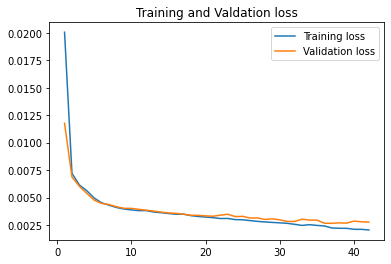

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

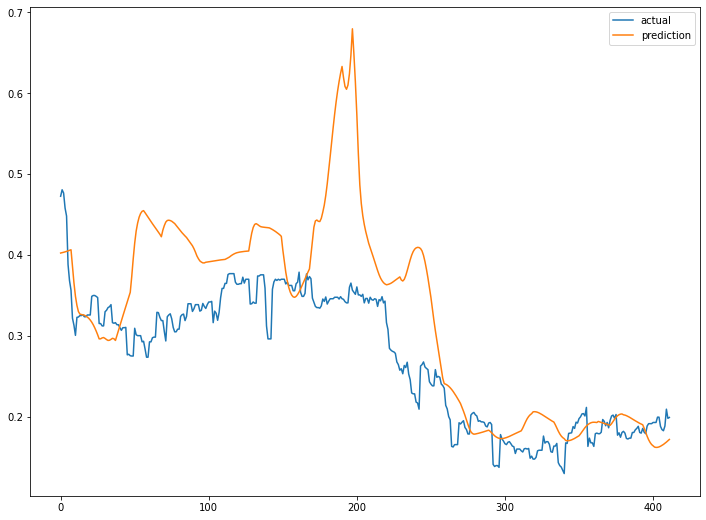

In [15]:
# 예측
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(test_label, pred)
mse = mean_squared_error(test_label, pred)
rmse = np.sqrt(mse)

0.007721717351713595


In [54]:
predict_score = []
predict_score = pd.DataFrame(predict_score, columns = ['MAE','MSE','RMSE'])

In [57]:
predict_score = pd.DataFrame(data=[[mae,mse,rmse]], columns=['MAE','MSE','RMSE'])

In [58]:
predict_score

,MAE,MSE,RMSE
0,0.06215,0.007722,0.087873
